Diabetes is a widespread health concern, and predicting its occurrence can be crucial for timely intervention. In this notebook, we'll develop a machine learning model to predict whether Pima Indian women in Phoenix have diabetes based on various characteristics. The dataset is sourced from the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA.

# 1. Exploratory Data Analysis (EDA)

Let's start by exploring the dataset to gain insights into the underlying patterns and relationships.

# 1.1 Loading the Data

In [19]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# Load the data
def load_data():
    data = pd.read_csv('F:\SOC 23\diabaties\diabetes.csv')
    return data

df = load_data()
df.head(10)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0
6,3,78,50,32,88,31.000,0.248,26,1
7,10,115,0,0,0,35.300,0.134,29,0
8,2,197,70,45,543,30.500,0.158,53,1
9,8,125,96,0,0,0.000,0.232,54,1


# 1.2 Data Exploration

In [21]:
# Data Exploration

# Displaying data shape and basic information
df.shape

(768, 9)

In [22]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# 1.3 Age Group Analysis

In [24]:
# Age Group
df['Age_Group'] = pd.cut(df['Age'], bins=[-1, 30, 50, float('inf')],
                         labels=['Young Adults', 'Middle-Aged', 'Seniors'])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group
0,6,148,72,35,0,33.600,0.627,50,1,Middle-Aged
1,1,85,66,29,0,26.600,0.351,31,0,Middle-Aged
2,8,183,64,0,0,23.300,0.672,32,1,Middle-Aged
3,1,89,66,23,94,28.100,0.167,21,0,Young Adults
4,0,137,40,35,168,43.100,2.288,33,1,Middle-Aged


# 1.4 Outlier Analysis

In [25]:
# Outlier Analysis
def outlier_thresholds (dataframe, col_name, q1=0.25, q3=0.75) :
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

In [26]:
outlier_thresholds(df, 'Insulin')

(-190.875, 318.125)

In [27]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    if outliers.any():
        return True
    else:
        return False

In [28]:
check_outlier(df, 'Insulin')

True

# 1.5 Capturing Numerical and Categorical Variables

In [29]:
def num_cat(df):
    num_cols = df.select_dtypes(include="number").columns.to_list()
    num_list = [col for col in df.columns if (df[col].nunique() > 10) & (col in num_cols)]

    cat_list = df.select_dtypes(include="object").columns.to_list()
    cat_list += [col for col in df.columns if (df[col].nunique() < 10) & (col not in cat_list)]

    return num_list,cat_list

num_list,cat_list = num_cat(df)

# 1.6 Analyzing Target Variable

Average of numerical variables according to the target variable.
Average of the target variable according to categorical variables

In [30]:
# Analyze the target variable
df.groupby('Outcome')[num_list].mean()
df.groupby('Outcome')[cat_list].count()

,Outcome,Age_Group
Outcome,,
0,500,500
1,268,268


# 1.7 Correlation Analysis

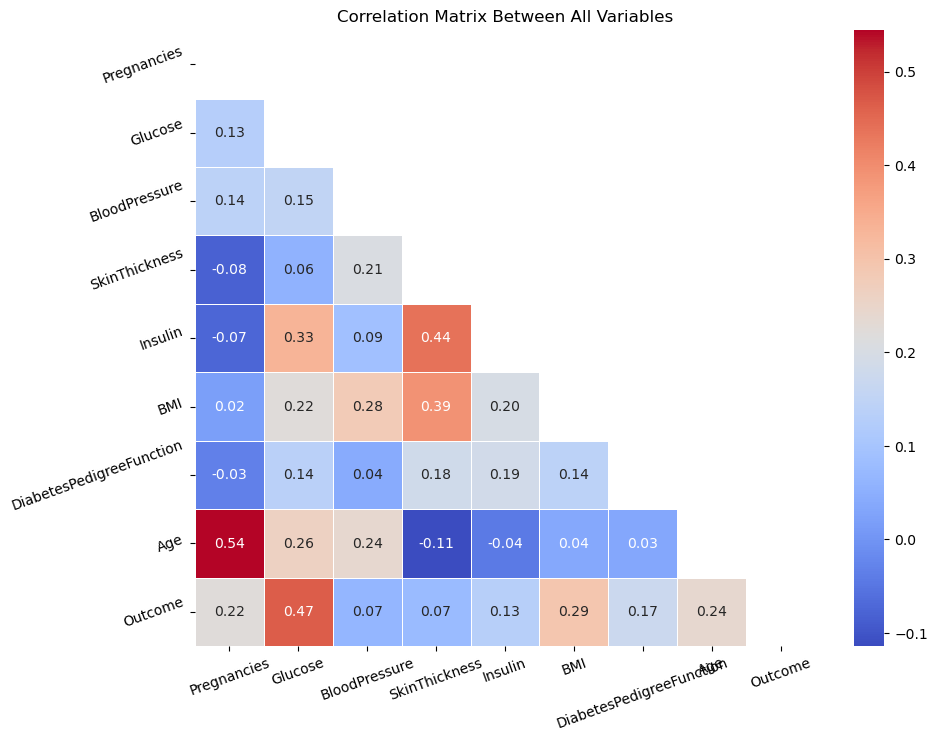

In [31]:
num_list2 = df.select_dtypes(include=['float64', 'int64'])

def correlation_analysis(dataframe):
    """
    Calculates and visualizes correlations between all numerical variables.

    Parameters
    - Data: Pandas DataFrame, the data set to be analyzed for correlation.
    """
    # Calculate correlations between all variables
    num_list2 = df.select_dtypes(include=['float64', 'int64'])
    corr_matrix = num_list2.corr()

    # Use heatmap for visualization
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5,mask=mask )
    plt.xticks(rotation=20)
    plt.yticks(rotation=20)
    plt.title("Correlation Matrix Between All Variables")
    plt.show()

correlation_analysis(num_list2)


# 2. Data Preprocessing and Feature Engineering

# 2.1 Re-assignment with Outlier Thresholds

In [32]:
low, up = outlier_thresholds(df, 'Insulin')
print(low,up)
df[((df['Insulin'] < low) | (df['Insulin'] > up))]['Insulin']

-190.875 318.125


8      543
13     846
54     342
111    495
139    325
153    485
186    495
220    478
228    744
231    370
247    680
248    402
258    375
286    545
296    360
360    325
370    465
375    325
392    415
409    579
415    474
480    328
486    480
519    326
574    330
584    600
612    321
645    440
655    540
695    480
707    335
710    387
715    392
753    510
Name: Insulin, dtype: int64

In [33]:
def replace_with_thresholds (dataframe, variable) :
    low_limit , up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_list:
    print(col, check_outlier(df, col))
print(" ")
for col in num_list:
    replace_with_thresholds (df, col)
    print(col, check_outlier(df, col))
print(" ")
for col in num_list:
    print(col, check_outlier (df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
 
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
 
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.837,3.344,0.000,1.000,3.000,6.000,13.500
Glucose,768.000,121.136,31.187,37.125,99.000,117.000,140.250,199.000
BloodPressure,768.000,70.685,14.197,35.000,62.000,72.000,80.000,107.000
SkinThickness,768.000,20.512,15.845,0.000,0.000,23.000,32.000,80.000
Insulin,768.000,73.653,93.576,0.000,0.000,30.500,127.250,318.125
BMI,768.000,32.125,7.050,13.350,27.300,32.000,36.600,50.550
DiabetesPedigreeFunction,768.000,0.459,0.286,0.078,0.244,0.372,0.626,1.200
Age,768.000,33.200,11.628,21.000,24.000,29.000,41.000,66.500
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [35]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group
0,6.000,148.000,72,35,0.000,33.600,0.627,50.000,1,Middle-Aged
1,1.000,85.000,66,29,0.000,26.600,0.351,31.000,0,Middle-Aged
2,8.000,183.000,64,0,0.000,23.300,0.672,32.000,1,Middle-Aged
3,1.000,89.000,66,23,94.000,28.100,0.167,21.000,0,Young Adults
4,0.000,137.000,40,35,168.000,43.100,1.200,33.000,1,Middle-Aged
5,5.000,116.000,74,0,0.000,25.600,0.201,30.000,0,Young Adults
6,3.000,78.000,50,32,88.000,31.000,0.248,26.000,1,Young Adults
7,10.000,115.000,35,0,0.000,35.300,0.134,29.000,0,Young Adults
8,2.000,197.000,70,45,318.125,30.500,0.158,53.000,1,Seniors
9,8.000,125.000,96,0,0.000,13.350,0.232,54.000,1,Seniors


# 2.2 Handling Missing Values

In [36]:
def replace_zero_with_nan(dataframe, columns):
    """
    Changes all zero values in certain columns to NaN.

    Parameters:
    - dataframe: Pandas DataFrame, the dataset to be processed.
    - columns: List, the column names where you want to make the zero values NaN.
    """
    dataframe.loc[:,columns] = dataframe[columns].replace(0, np.nan)

replace_zero_with_nan(df, columns=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                                   'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [37]:
# We need to fill NaN to be able to build the model.
missing_ones = df.isnull().sum()[df.isnull().sum()>0].index

def fill_based_cat(data,columns,based_cat,metric):
    data = data.copy()
    for col in columns:
        data[col] = data[col].fillna(df.groupby(based_cat)[col].transform(metric))
    return data

df = fill_based_cat(df,missing_ones,based_cat="Age_Group",metric="median")

In [38]:
all(df['Glucose'] == 'NaN')

False

# 2.3 Creating New Variables

In [39]:
# Pregnancy Category
df['Pregnancy_Category'] = pd.cut(df['Pregnancies'], bins=[-1, 0, 1, float('inf')],
                                  labels=['Nulliparous', 'Primiparous', 'Multiparous'])

# Blood Pressure Category
df['BloodPressure_Category'] = pd.cut(df['BloodPressure'], bins=[-1, 80, 90, float('inf')],
                                      labels=['Normal', 'Elevated', 'Hypertensive'])

# BMI Category
df['BMI_Category'] = pd.cut(df['BMI'], bins=[-1, 18.5, 24.9, 29.9, float('inf')],
                            labels=['Underweight', 'Normal Weight', 'Overweight', 'Obese'])

# Insulin Sensitivity
df['Insulin_Sensitivity'] = df['Glucose'] / (df['Insulin'] * df['BMI'])

# Insulin Resistance Index
df['Insulin_Resistance_Index'] = df['Insulin'] * df['Glucose'] / df['BMI']

# Triceps Skin Fold Thickness Indicator
df['Triceps_Skin_Fold_Indicator'] = df['SkinThickness'].apply(lambda x: 1 if 20 <= x <= 30 else 0)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group,Pregnancy_Category,BloodPressure_Category,BMI_Category,Insulin_Sensitivity,Insulin_Resistance_Index,Triceps_Skin_Fold_Indicator
0,6.000,148.000,72,35.000,136.000,33.600,0.627,50.000,1,Middle-Aged,Multiparous,Normal,Obese,0.032,599.048,0
1,1.000,85.000,66,29.000,136.000,26.600,0.351,31.000,0,Middle-Aged,Primiparous,Normal,Overweight,0.023,434.586,1
2,8.000,183.000,64,31.000,136.000,23.300,0.672,32.000,1,Middle-Aged,Multiparous,Normal,Normal Weight,0.058,1068.155,0
3,1.000,89.000,66,23.000,94.000,28.100,0.167,21.000,0,Young Adults,Primiparous,Normal,Overweight,0.034,297.722,1
4,0.000,137.000,40,35.000,168.000,43.100,1.200,33.000,1,Middle-Aged,Nulliparous,Normal,Obese,0.019,534.014,0


# 2.4 Encoding Categorical Variables

In [40]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, categorical_cols=['Pregnancy_Category', 'BloodPressure_Category',
                                           'BMI_Category' , 'Age_Group'])

# 2.5 Standardization

In [41]:
scaler = StandardScaler()
df[num_list] = scaler.fit_transform(df[num_list])
df[num_list].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.647,0.862,0.093,0.680,-0.024,0.209,0.589,1.446
1,-0.849,-1.159,-0.330,-0.012,-0.024,-0.784,-0.378,-0.189
2,1.246,1.985,-0.471,0.219,-0.024,-1.253,0.747,-0.103
3,-0.849,-1.031,-0.330,-0.704,-0.679,-0.571,-1.023,-1.050
4,-1.148,0.509,-2.163,0.680,0.475,1.558,2.597,-0.017


# 3. Model Development

# 3.1 Splitting the Data

In [42]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

# 3.2 Random Forest Classifier

In [45]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
score=accuracy_score(y_pred, y_test)
print(score)

0.7705627705627706


# Logistic Regression


In [47]:
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression().fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
score_lr = accuracy_score(y_pred_lr, y_test)
print("Logistic Regression Accuracy:", score_lr)


Logistic Regression Accuracy: 0.7705627705627706


C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Decision Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier


dt_model = DecisionTreeClassifier(random_state=46).fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
score_dt = accuracy_score(y_pred_dt, y_test)
print("Decision Trees Accuracy:", score_dt)


Decision Trees Accuracy: 0.7229437229437229


# XGBoost

In [49]:
pip install scikit-learn xgboost


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 99.8/99.8 MB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [50]:
from xgboost import XGBClassifier


xgb_model = XGBClassifier(random_state=46).fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
score_xgb = accuracy_score(y_pred_xgb, y_test)
print("XGBoost Accuracy:", score_xgb)


XGBoost Accuracy: 0.7445887445887446


# SVM ,Naive Bayes and KNN

In [51]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# SVM
svm_model = SVC(random_state=46).fit(X_train, y_train)
y_svm_pred = svm_model.predict(X_test)
svm_score = accuracy_score(y_svm_pred, y_test)
print("SVM Accuracy:", svm_score)

# Naive Bayes
nb_model = GaussianNB().fit(X_train, y_train)
y_nb_pred = nb_model.predict(X_test)
nb_score = accuracy_score(y_nb_pred, y_test)
print("Naive Bayes Accuracy:", nb_score)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier().fit(X_train, y_train)
y_knn_pred = knn_model.predict(X_test)
knn_score = accuracy_score(y_knn_pred, y_test)
print("k-Nearest Neighbors Accuracy:", knn_score)


SVM Accuracy: 0.6493506493506493
Naive Bayes Accuracy: 0.7056277056277056
k-Nearest Neighbors Accuracy: 0.6103896103896104


Highest accuracy is given by RandomForest and logistic regression which is around 77%

# 4. Feature Importance

# 4.1 Plotting Feature Importance

    Value                              Feature
1   0.191                              Glucose
9   0.111             Insulin_Resistance_Index
5   0.099                                  BMI
6   0.091             DiabetesPedigreeFunction
7   0.088                                  Age
8   0.078                  Insulin_Sensitivity
4   0.071                              Insulin
0   0.060                          Pregnancies
3   0.058                        SkinThickness
2   0.055                        BloodPressure
18  0.020                Age_Group_Middle-Aged
17  0.019                   BMI_Category_Obese
15  0.011           BMI_Category_Normal Weight
10  0.009          Triceps_Skin_Fold_Indicator
13  0.008      BloodPressure_Category_Elevated
16  0.008              BMI_Category_Overweight
12  0.007       Pregnancy_Category_Multiparous
11  0.007       Pregnancy_Category_Primiparous
19  0.006                    Age_Group_Seniors
14  0.005  BloodPressure_Category_Hypertensive


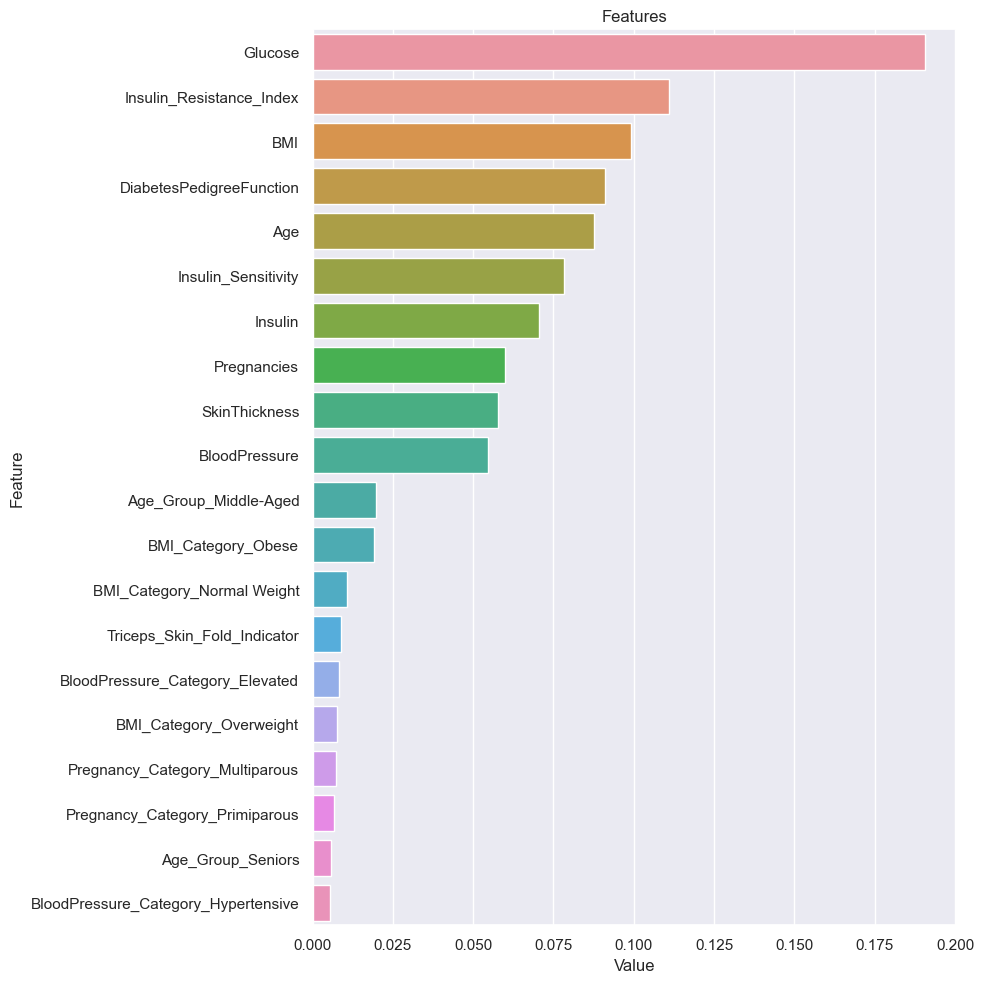

In [44]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

Conclusion
In this we explored the dataset, performed necessary preprocessing steps, and developed a Random Forest model to predict diabetes. Feature importance analysis provides insights into the crucial factors influencing the predictions.